Copyright 2015-2025 Universidad Complutense de Madrid (UCM)

This file contains code adapted from Numina https://github.com/guaix-ucm/numina.

It was developed by N. Cardiel for students of the Astrophysics Master (UCM).

This is an adapted version for lectures at ULS (Chile).

* License:
SPDX-License-Identifier: GPL-3.0+

* Modified by:
C. Cabello (UCM; Spain), 
L. Costantin (CAB; Spain)

## Sky subtraction

### Imports

In [1]:
'''
:Settings:
conda activate uls_2025

:History:
23 Mar 25:  version 1.0
'''

import numpy as np
import teareduce as tea
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from astropy.io import fits
from tqdm.notebook import tqdm

tea.avoid_astropy_warnings(True)

__version__ = "1.0"
__author__  = "Cristina Cabello (UCM, Spain) and Luca Costantin (CAB, Spain)"


### Read files

In [2]:
galaxy_ID        = 'NGC2366'
specphot_star_ID = 'HR3454'

## MODIFY THE FOLLOWING

abs_path = f'/home/diegosuzaku/NGC2366Workshop'

dir_calibration = Path(f'{abs_path}/calibration/spectroscopy')

#### Galaxy

In [3]:
input_filename = dir_calibration / f'combined_{galaxy_ID}.fits'
data = fits.getdata(input_filename)

naxis2, naxis1 = data.shape
print(f'NAXIS1={naxis1}')
print(f'NAXIS2={naxis2}')

NAXIS1=2039
NAXIS2=1191


Read wavelength calibration parameters from header

In [4]:
header = fits.getheader(input_filename)

cunit1 = 1 * u.Unit(header['cunit1'])
crpix1 = header['crpix1'] * u.pixel
crval1 = header['crval1'] * u.Unit(cunit1)
cdelt1 = header['cdelt1'] * u.Unit(cunit1) / u.pixel
print(f'crpix1: {crpix1}')
print(f'crval1: {crval1}')
print(f'cdelt1: {cdelt1}')
print(f'cunit1: {cunit1}')

crpix1: 1.0 pix
crval1: 4.2130519482283e-07 m
cdelt1: 2.0102772216371e-10 m / pix
cunit1: 1.0 m


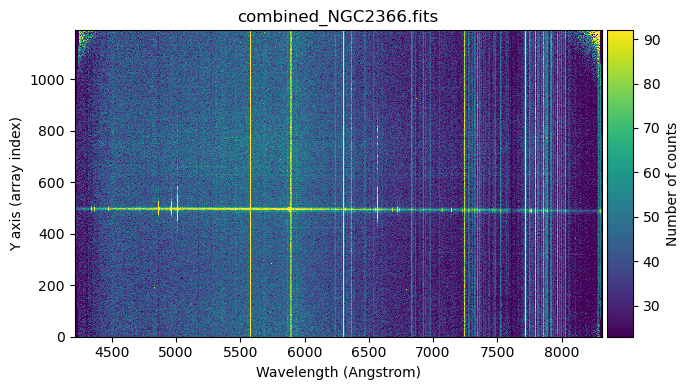

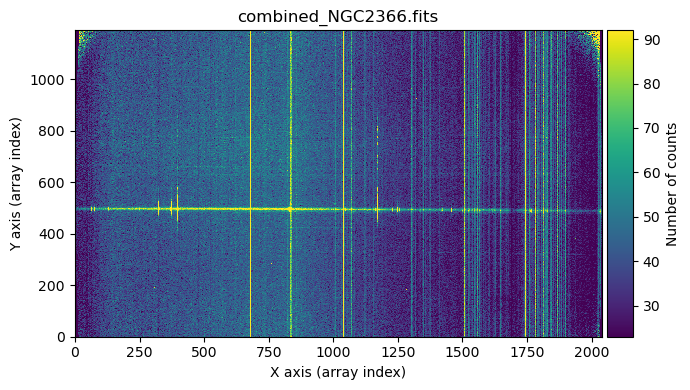

In [5]:
vmin, vmax = np.percentile(data, [5, 99])
for iplot in range(2):
    fig, ax = plt.subplots(figsize=(7, 4))
    if iplot == 0:
        tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax, 
                   title=f"{str(input_filename).split('/')[-1]}", cmap='viridis',
                   crpix1=crpix1, crval1=crval1, cdelt1=cdelt1, cunit1=cunit1)
    else:
        tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax, 
                   title=f"{str(input_filename).split('/')[-1]}", 
                   cmap='viridis', aspect='auto')

    plt.tight_layout()
    plt.show()

We can look at the average spectrum and define the sky regions. We can see a gradient in the sky continuum along the spatial direction. We can model the sky level with a polynomial function using `polfit_residuals_with_sigma_rejection()`.

In [12]:
# spectral regions
spectral_region1 = (390, 410)
spectral_region2 = (1160, 1210)
spectral_regions = np.r_[spectral_region1[0]:(spectral_region1[1]+1),
                         spectral_region2[0]:(spectral_region2[1]+1)]

# sky regions
sky_region1 = (50, 250)
sky_region2 = (800, 1190)
sky_regions = np.r_[sky_region1[0]:(sky_region1[1]+1), 
                    sky_region2[0]:(sky_region2[1]+1)]

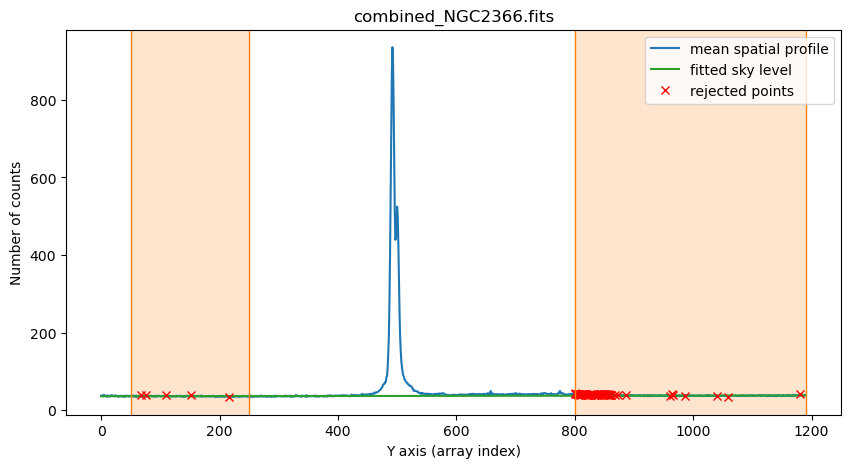

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
xp = np.arange(naxis2)
yp = np.mean(data[:, spectral_regions], axis=1)
ax.plot(xp, yp, label='mean spatial profile')
ax.set_xlabel('Y axis (array index)')
ax.set_ylabel('Number of counts')
ax.set_title(f"{str(input_filename).split('/')[-1]}")

# fit of the sky level
xfit = sky_regions
yfit = yp[sky_regions]

(poly_funct, 
 yres, 
 reject) = tea.polfit_residuals_with_sigma_rejection(x=xfit,
                                                     y=yfit,
                                                     deg=1,
                                                     times_sigma_reject=3)

xpredict = np.arange(naxis2)
ypredict = poly_funct(xpredict)
ax.plot(xpredict, ypredict, color='C2', ls='-', label='fitted sky level')
ax.plot(xfit[reject], yfit[reject], 'rx', label='rejected points')
ax.legend()

# display sky regions
ymin, ymax = ax.get_ylim()
for r in [sky_region1, sky_region2]:
    ax.axvline(r[0], lw=1, color='C1')
    ax.axvline(r[1], lw=1, color='C1')
    rect = patches.Rectangle((r[0], ymin), r[1]-r[0], ymax-ymin, 
                             facecolor='C1', alpha=0.2)
    ax.add_patch(rect)

In [14]:
data_sky = data[sky_regions]

# initialize 2D full frame sky image
data_sky_fullframe = np.zeros((naxis2, naxis1))

# fit each image column
xfit = sky_regions
xpredict = np.arange(naxis2)

for i in tqdm(range(naxis1)):
    yfit = data_sky[:, i]
    (poly_funct, 
     yres, 
     reject) = tea.polfit_residuals_with_sigma_rejection(x=xfit,
                                                         y=yfit,
                                                         deg=1,
                                                         times_sigma_reject=3)
    
    data_sky_fullframe[:, i] = poly_funct(xpredict)


  0%|          | 0/2039 [00:00<?, ?it/s]

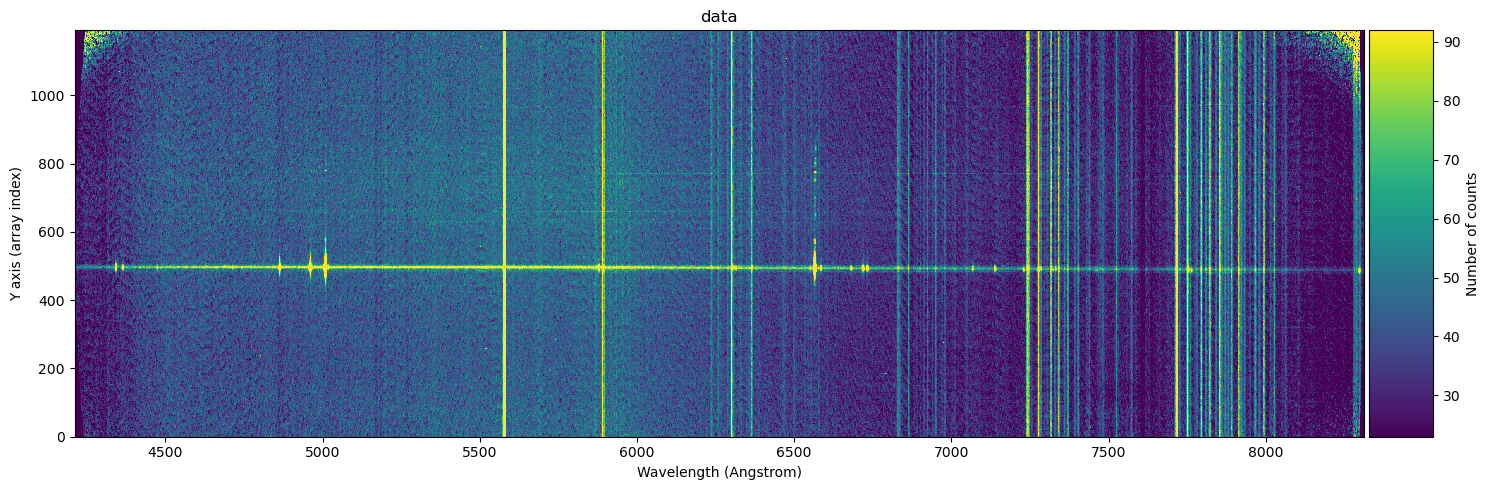

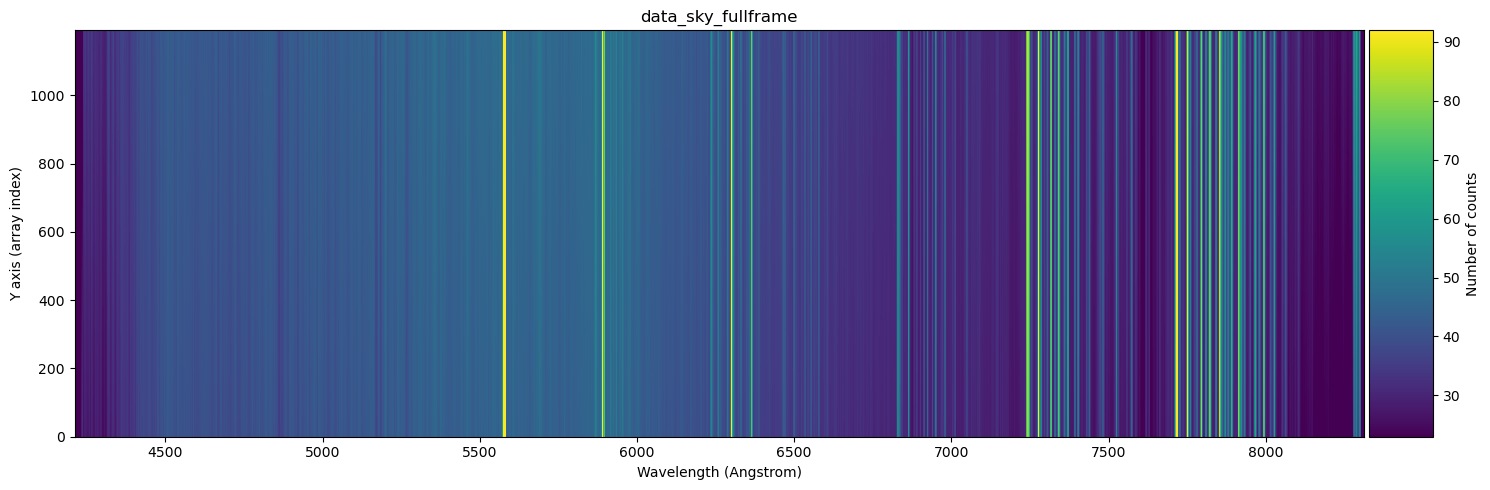

In [15]:
for data_, title in zip([data, data_sky_fullframe],
                       ['data', 'data_sky_fullframe']):
    fig, ax = plt.subplots(figsize=(15, 5))
    tea.imshow(fig, ax, data_, vmin=vmin, vmax=vmax, title=title, 
               cmap='viridis', crpix1=crpix1, crval1=crval1, 
               cdelt1=cdelt1, cunit1=cunit1)
    plt.tight_layout()
    plt.show()

We can subtract the sky frame from the calibrated image.

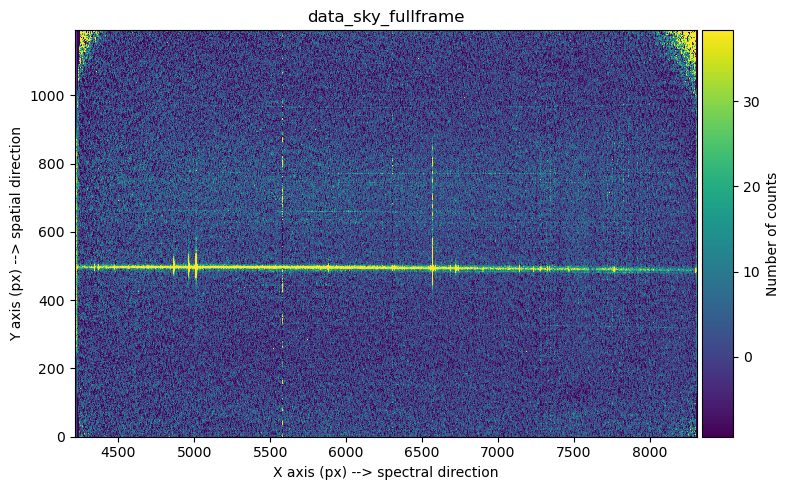

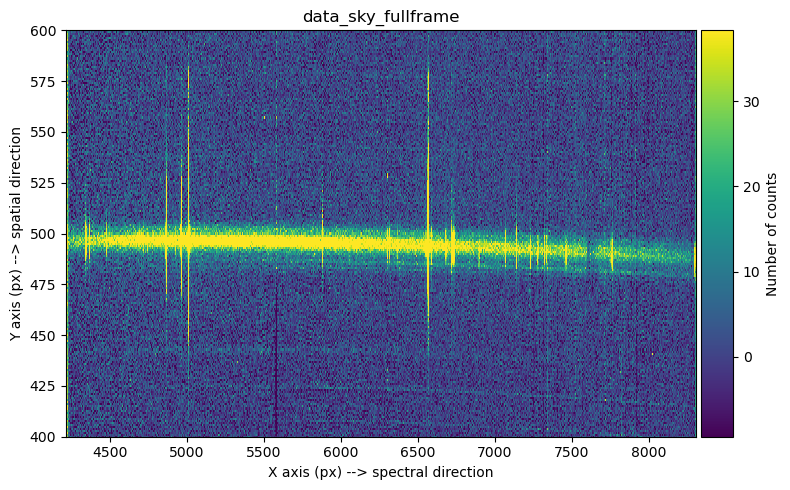

In [16]:
data_sky_subtracted = data - data_sky_fullframe

vmin, vmax = np.percentile(data_sky_subtracted, [5, 99.5])

for iplot in range(2):
    fig, ax = plt.subplots(figsize=(8, 5))
    tea.imshow(fig, ax, data_sky_subtracted, vmin=vmin, vmax=vmax, 
               title=title, cmap='viridis', crpix1=crpix1, crval1=crval1, 
               cdelt1=cdelt1, cunit1=cunit1)
    if iplot == 1:
        ax.set_ylim(400, 600)
    ax.set_xlabel('X axis (px) --> spectral direction')
    ax.set_ylabel('Y axis (px) --> spatial direction')
    plt.tight_layout()
    plt.show()

#### Save results

In [17]:
hdu = fits.PrimaryHDU(data=data_sky_subtracted, header=header)
output_filename = Path(input_filename.parent) / f'{input_filename.stem}_skysub.fits'
print(f'Saving file: {output_filename}')
hdu.writeto(output_filename, overwrite=True)

Saving file: /home/diegosuzaku/NGC2366Workshop/calibration/spectroscopy/combined_NGC2366_skysub.fits


### Repeat the same background subtraction for the spectro-photometric star

NAXIS1=2039
NAXIS2=1191
crpix1: 1.0 pix
crval1: 4.2130519482283e-07 m
cdelt1: 2.0102772216371e-10 m / pix
cunit1: 1.0 m


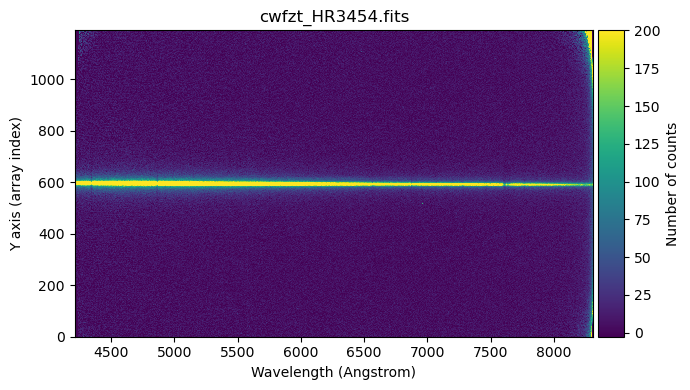

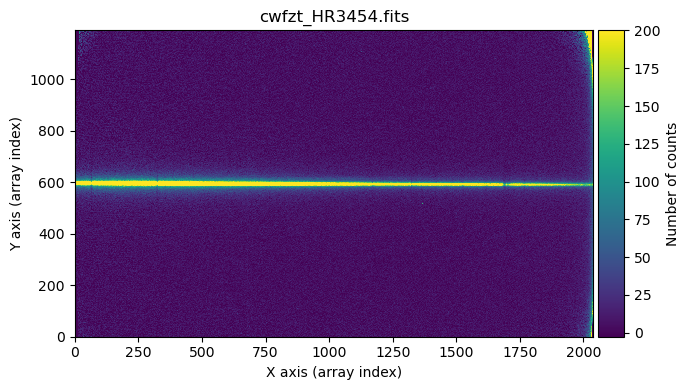

In [18]:
input_filename = dir_calibration / f'cwfzt_{specphot_star_ID}.fits'
data = fits.getdata(input_filename)

naxis2, naxis1 = data.shape
print(f'NAXIS1={naxis1}')
print(f'NAXIS2={naxis2}')

header = fits.getheader(input_filename)

cunit1 = 1 * u.Unit(header['cunit1'])
crpix1 = header['crpix1'] * u.pixel
crval1 = header['crval1'] * u.Unit(cunit1)
cdelt1 = header['cdelt1'] * u.Unit(cunit1) / u.pixel
print(f'crpix1: {crpix1}')
print(f'crval1: {crval1}')
print(f'cdelt1: {cdelt1}')
print(f'cunit1: {cunit1}')

vmin, vmax = np.percentile(data, [5, 99])
for iplot in range(2):
    fig, ax = plt.subplots(figsize=(7, 4))
    if iplot == 0:
        tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax, 
                   title=f"{str(input_filename).split('/')[-1]}", cmap='viridis',
                   crpix1=crpix1, crval1=crval1, cdelt1=cdelt1, cunit1=cunit1)
    else:
        tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax, 
                   title=f"{str(input_filename).split('/')[-1]}", 
                   cmap='viridis', aspect='auto')

    plt.tight_layout()
    plt.show()

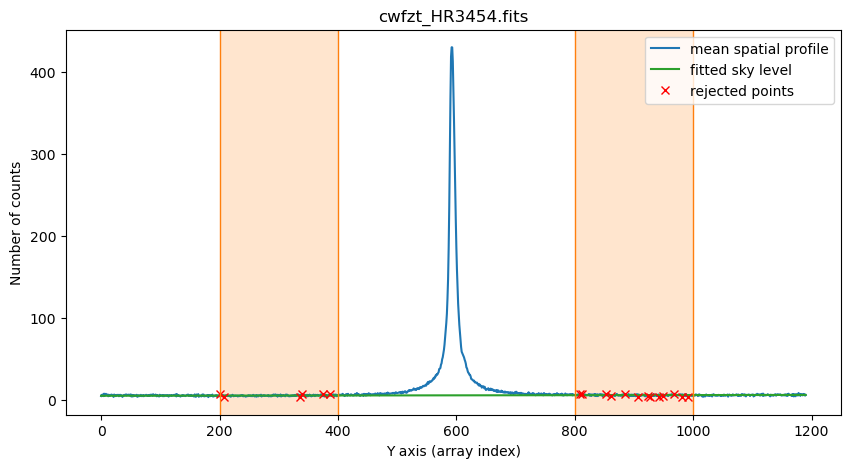

In [19]:
# spectral regions
spectral_region1 = (390, 410)
spectral_region2 = (1160, 1210)
spectral_regions = np.r_[spectral_region1[0]:(spectral_region1[1]+1),
                         spectral_region2[0]:(spectral_region2[1]+1)]

# sky regions
sky_region1 = (200, 400)
sky_region2 = (800, 1000)
sky_regions = np.r_[sky_region1[0]:(sky_region1[1]+1), 
                    sky_region2[0]:(sky_region2[1]+1)]

fig, ax = plt.subplots(figsize=(10, 5))
xp = np.arange(naxis2)
yp = np.mean(data[:, spectral_regions], axis=1)
ax.plot(xp, yp, label='mean spatial profile')
ax.set_xlabel('Y axis (array index)')
ax.set_ylabel('Number of counts')
ax.set_title(f"{str(input_filename).split('/')[-1]}")

# fit of the sky level
xfit = sky_regions
yfit = yp[sky_regions]

(poly_funct, 
 yres, 
 reject) = tea.polfit_residuals_with_sigma_rejection(x=xfit,
                                                     y=yfit,
                                                     deg=1,
                                                     times_sigma_reject=3)

xpredict = np.arange(naxis2)
ypredict = poly_funct(xpredict)
ax.plot(xpredict, ypredict, color='C2', ls='-', label='fitted sky level')
ax.plot(xfit[reject], yfit[reject], 'rx', label='rejected points')
ax.legend()

# display sky regions
ymin, ymax = ax.get_ylim()
for r in [sky_region1, sky_region2]:
    ax.axvline(r[0], lw=1, color='C1')
    ax.axvline(r[1], lw=1, color='C1')
    rect = patches.Rectangle((r[0], ymin), r[1]-r[0], ymax-ymin, 
                             facecolor='C1', alpha=0.2)
    ax.add_patch(rect)

  0%|          | 0/2039 [00:00<?, ?it/s]

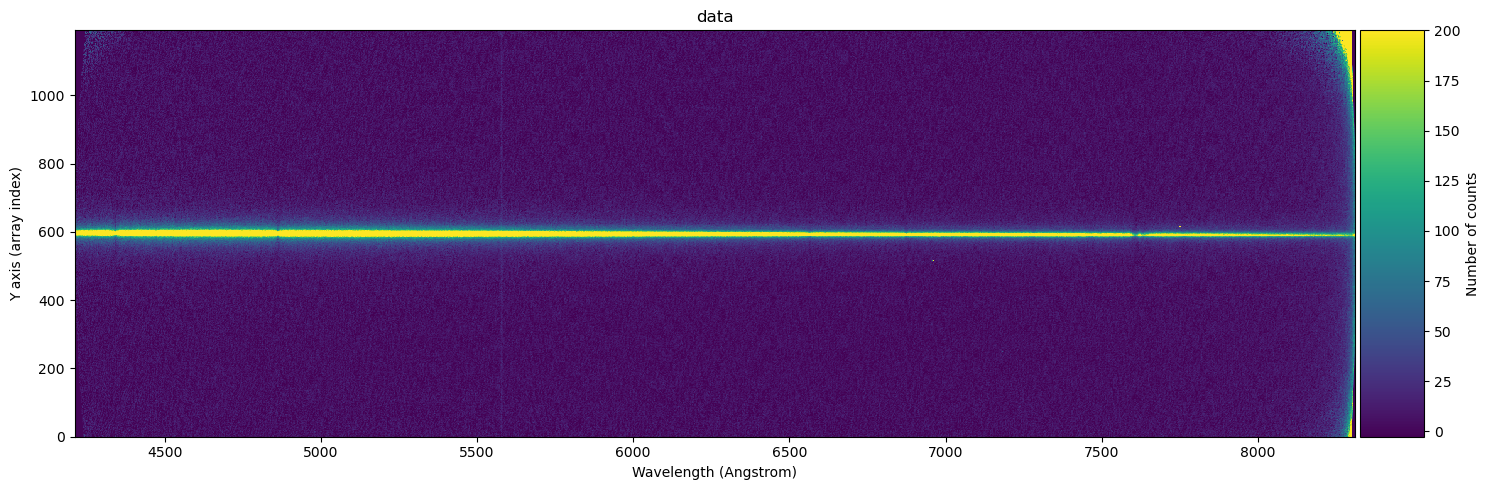

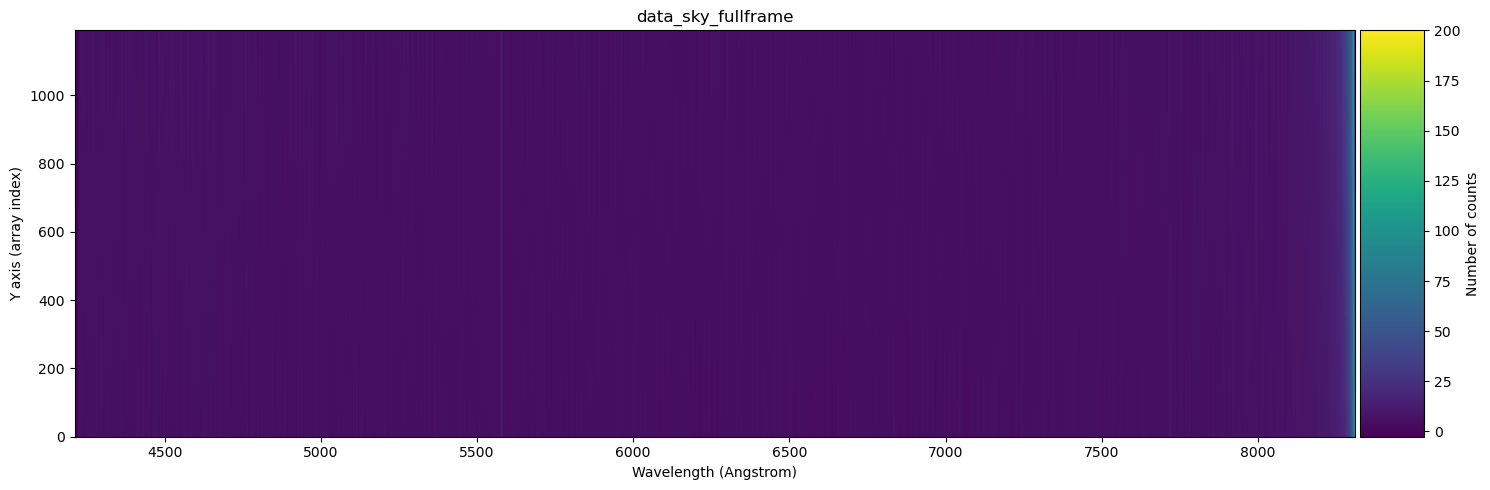

In [20]:
data_sky = data[sky_regions]

# initialize 2D full frame sky image
data_sky_fullframe = np.zeros((naxis2, naxis1))

# fit each image column
xfit = sky_regions
xpredict = np.arange(naxis2)

for i in tqdm(range(naxis1)):
    yfit = data_sky[:, i]
    (poly_funct, 
     yres, 
     reject) = tea.polfit_residuals_with_sigma_rejection(x=xfit,
                                                         y=yfit,
                                                         deg=1,
                                                         times_sigma_reject=3)
    
    data_sky_fullframe[:, i] = poly_funct(xpredict)

for data_, title in zip([data, data_sky_fullframe],
                       ['data', 'data_sky_fullframe']):
    fig, ax = plt.subplots(figsize=(15, 5))
    tea.imshow(fig, ax, data_, vmin=vmin, vmax=vmax, title=title, 
               cmap='viridis', crpix1=crpix1, crval1=crval1, 
               cdelt1=cdelt1, cunit1=cunit1)
    plt.tight_layout()
    plt.show()

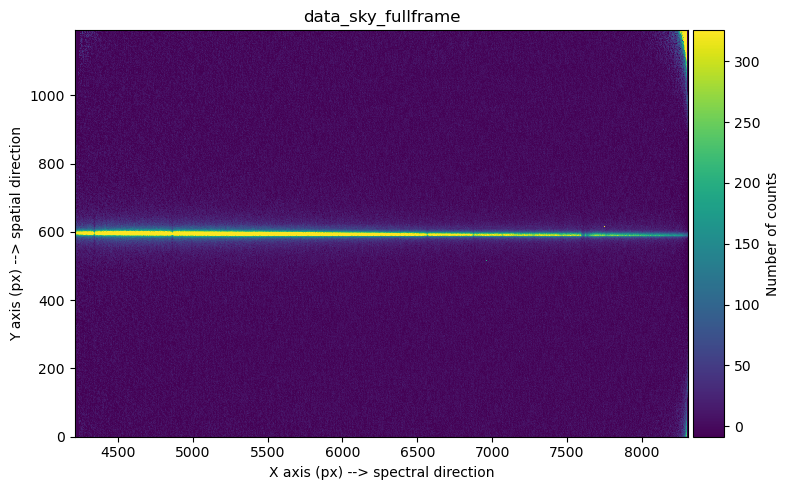

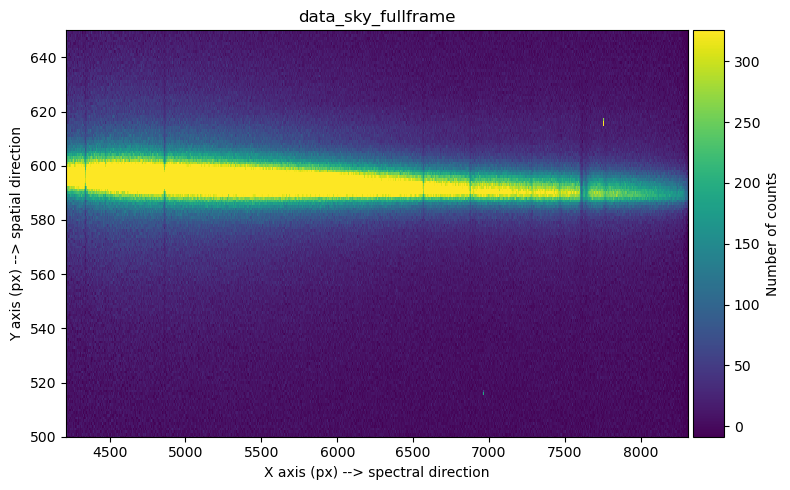

In [21]:
data_sky_subtracted = data - data_sky_fullframe

vmin, vmax = np.percentile(data_sky_subtracted, [5, 99.5])

for iplot in range(2):
    fig, ax = plt.subplots(figsize=(8, 5))
    tea.imshow(fig, ax, data_sky_subtracted, vmin=vmin, vmax=vmax, 
               title=title, cmap='viridis', crpix1=crpix1, crval1=crval1, 
               cdelt1=cdelt1, cunit1=cunit1)
    if iplot == 1:
        ax.set_ylim(500, 650)
    ax.set_xlabel('X axis (px) --> spectral direction')
    ax.set_ylabel('Y axis (px) --> spatial direction')
    plt.tight_layout()
    plt.show()

In [22]:
hdu = fits.PrimaryHDU(data=data_sky_subtracted, header=header)
output_filename = Path(input_filename.parent) / f'{input_filename.stem}_skysub.fits'
print(f'Saving file: {output_filename}')
hdu.writeto(output_filename, overwrite=True)

Saving file: /home/diegosuzaku/NGC2366Workshop/calibration/spectroscopy/cwfzt_HR3454_skysub.fits
